In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import pyspedas
from pytplot import get_data

# Load magnetic field data
trange = ['2023-03-16/00:00', '2023-03-18/00:00']
mag_vars = pyspedas.psp.fields(trange=trange, datatype='mag_rtn', level='l2', time_clip=True, get_support_data=True)

# Load solar wind proton data (which includes sun distance)
spi_vars = pyspedas.psp.spi(trange=trange, datatype='spi_sf00_l3_mom', level='l3', time_clip=True)

# Get magnetic field and time data
mag_data = get_data('psp_fld_l2_mag_RTN')
mag_time, mag_field = mag_data.times, mag_data.y

# Get sun distance and time data
sun_dist_data = get_data('psp_spi_SUN_DIST')
sun_dist_time, sun_dist = sun_dist_data.times, sun_dist_data.y

print(f"Magnetic field data shape: {mag_field.shape}")
print(f"Sun distance data shape: {sun_dist.shape}")

18-Sep-24 16:44:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2023/
18-Sep-24 16:44:17: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031600_v02.cdf
18-Sep-24 16:44:18: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031606_v02.cdf
18-Sep-24 16:44:18: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031612_v02.cdf
18-Sep-24 16:44:18: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031618_v02.cdf
18-Sep-24 16:44:18: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031700_v02.cdf
18-Sep-24 16:44:19: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031706_v02.cdf
18-Sep-24 16:44:19: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031712_v02.cdf
18-Sep-24 16:44:19: File is current: psp_data/fields/l2/mag_rtn/2023/psp_fld_l2_mag_rtn_2023031718_v02.cdf
18-Sep-24 16:45:45: Downloading re

Magnetic field data shape: (50624304, 3)
Sun distance data shape: (67110,)


In [12]:
# Create an interpolation function
sun_dist_interp = interpolate.interp1d(sun_dist_time, sun_dist, kind='linear', bounds_error=False, fill_value="extrapolate")

# Interpolate sun distance to match magnetic field data times
sun_dist_interpolated = sun_dist_interp(mag_time)

print(f"Interpolated sun distance shape: {sun_dist_interpolated.shape}")

# Convert kilometers to astronomical units (AU)
au_in_km = 149597870.7
sun_dist_au = sun_dist_interpolated / au_in_km

print(f"Sun distance range: {sun_dist_au.min():.4f} - {sun_dist_au.max():.4f} AU")

Interpolated sun distance shape: (50624304,)
Sun distance range: 0.0618 - 0.1233 AU


In [13]:
# Calculate R squared (distance in AU squared)
r_squared = sun_dist_au ** 2

# Normalize magnetic field components
normalized_mag_field = mag_field * r_squared[:, np.newaxis]

print(f"Normalized magnetic field shape: {normalized_mag_field.shape}")

# Calculate the magnitude of the original and normalized magnetic field
mag_field_magnitude = np.linalg.norm(mag_field, axis=1)
normalized_mag_field_magnitude = np.linalg.norm(normalized_mag_field, axis=1)

print(f"Original B magnitude range: {mag_field_magnitude.min():.2f} - {mag_field_magnitude.max():.2f} nT")
print(f"Normalized B magnitude range: {normalized_mag_field_magnitude.min():.2f} - {normalized_mag_field_magnitude.max():.2f} nT*AU^2")

Normalized magnetic field shape: (50624304, 3)
Original B magnitude range: 0.95 - 803.68 nT
Normalized B magnitude range: 0.01 - 3.44 nT*AU^2


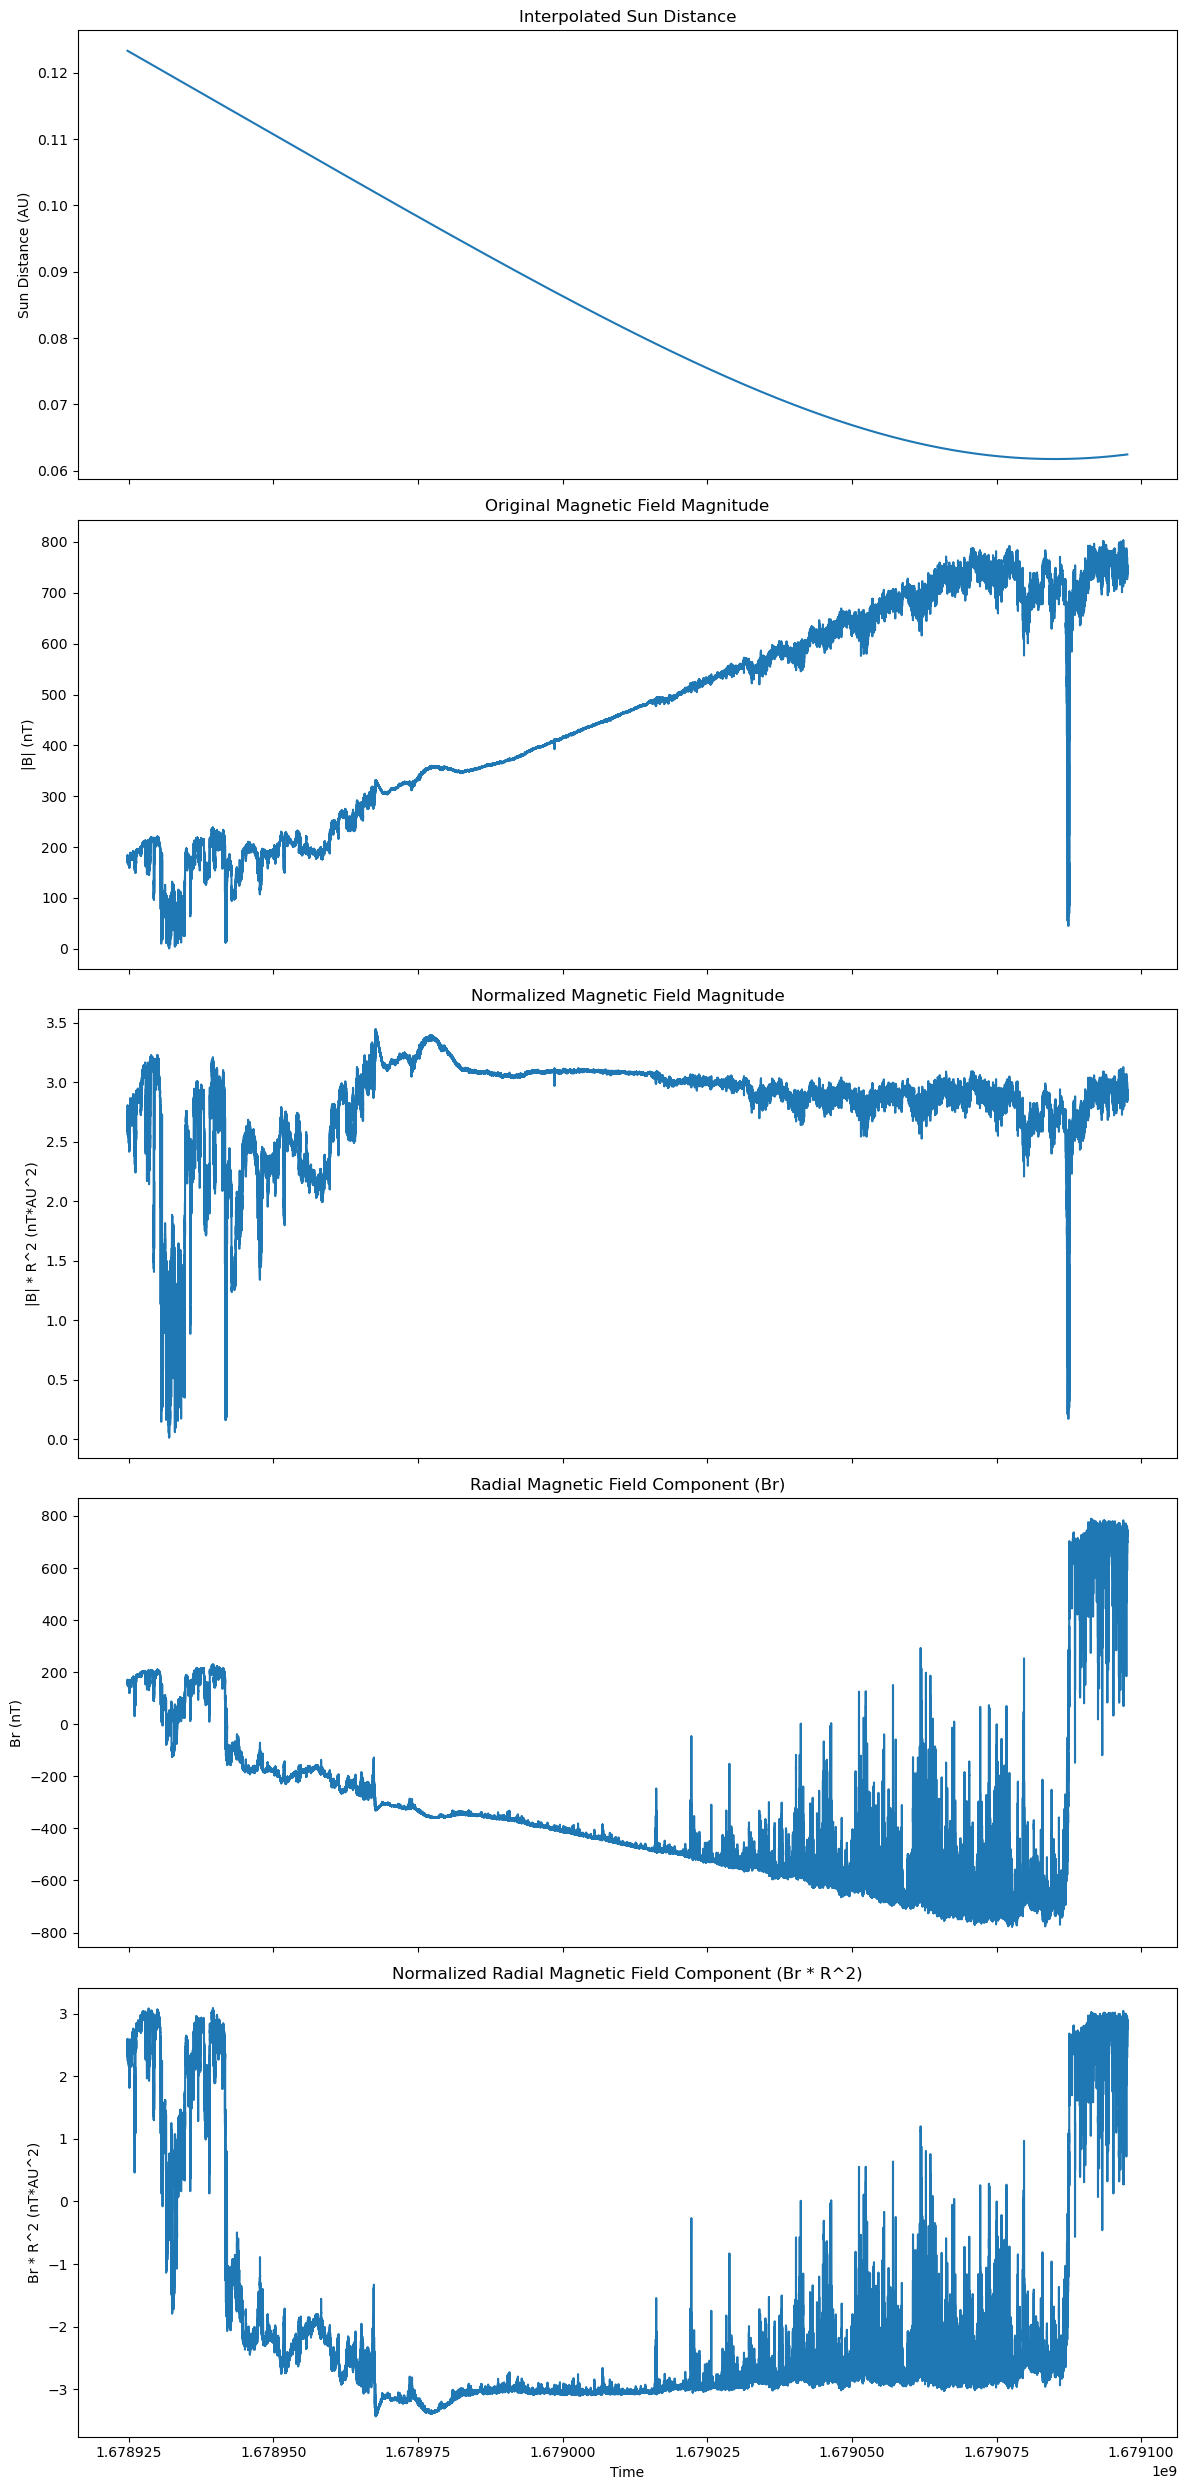

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 25), sharex=True)

# Plot sun distance
ax1.plot(mag_time, sun_dist_au)
ax1.set_ylabel('Sun Distance (AU)')
ax1.set_title('Interpolated Sun Distance')

# Plot original magnetic field magnitude
ax2.plot(mag_time, mag_field_magnitude)
ax2.set_ylabel('|B| (nT)')
ax2.set_title('Original Magnetic Field Magnitude')

# Plot normalized magnetic field magnitude
ax3.plot(mag_time, normalized_mag_field_magnitude)
ax3.set_ylabel('|B| * R^2 (nT*AU^2)')
ax3.set_title('Normalized Magnetic Field Magnitude')

# Plot Br component
ax4.plot(mag_time, mag_field[:, 0])  # Assuming Br is the first component
ax4.set_ylabel('Br (nT)')
ax4.set_title('Radial Magnetic Field Component (Br)')

# Plot normalized Br component
ax5.plot(mag_time, normalized_mag_field[:, 0])  # Assuming Br is the first component
ax5.set_ylabel('Br * R^2 (nT*AU^2)')
ax5.set_xlabel('Time')
ax5.set_title('Normalized Radial Magnetic Field Component (Br * R^2)')

plt.tight_layout()
plt.show()